Dataset

The dataset used is the UrbanSound8K dataset, which is a collection 8,732 audio samples of urban sounds belonging to 10 classes - air conditioner, car horn, children playing, dog bark, drilling, engine idling, gun shot, jackhammer, siren, and street music. The duration of each audio file is 4 seconds or less.

Importing necessary libraries

In [1]:
import os
import time
import librosa
import zipfile
import numpy as np
import pandas as pd
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
from sklearn.model_selection import train_test_split

Downloading dataset

In [2]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2024-01-17 02:41:10--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2024-01-17 02:41:11--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  16.6MB/s    in 5m 42s  

2024-01-17 02:46:53 (16.8 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [3]:
data=pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
data['file'] = data.apply(lambda row: f'fold{row["fold"]}/{row["slice_file_name"]}', axis=1)
data['file'] = data['file'].apply(lambda x: f'UrbanSound8K/audio/{x}')
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,file
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav


In [6]:
data.groupby('class').slice_file_name.count()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

Sample waveform

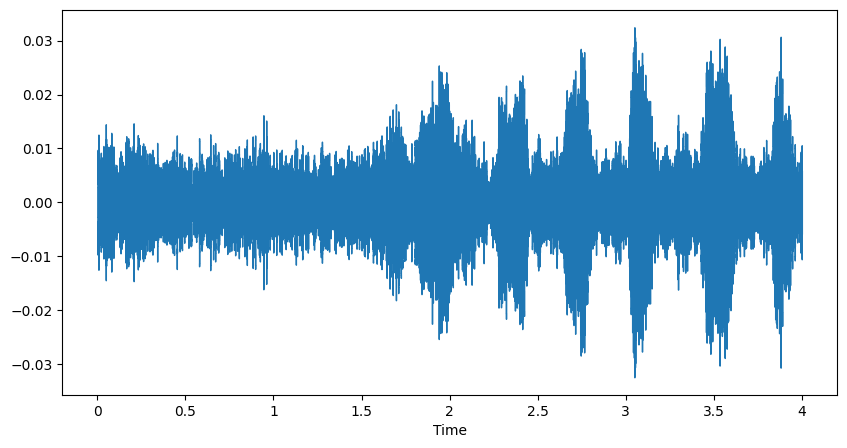

In [9]:
filename='UrbanSound8K/audio/fold5/100263-2-0-126.wav'
data,sample_rate=librosa.load(filename)
plt.figure(figsize=(10,5))
librosa.display.waveshow(y=data,sr=sample_rate)

Features finalised for classification

MFCC features

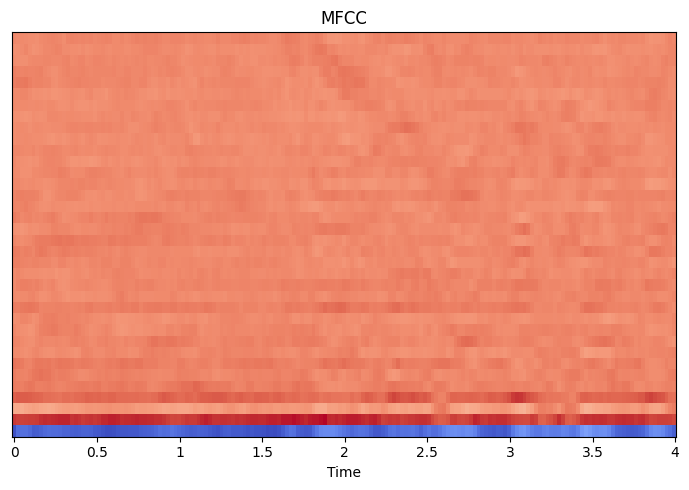

In [10]:
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=36)
melspectrogram =librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=36,fmax=8000)

plt.figure(figsize=(7,5))
librosa.display.specshow(mfccs, x_axis='time')
plt.title('MFCC')
plt.tight_layout()


In [12]:
print(mfccs)

[[-4.4126379e+02 -4.0525671e+02 -4.0120792e+02 ... -3.9011331e+02
  -4.0182715e+02 -4.2271951e+02]
 [ 8.9027626e+01  8.2458878e+01  8.0581108e+01 ...  8.2364380e+01
   7.9482063e+01  7.3826080e+01]
 [-4.8367973e+01 -4.6065727e+01 -4.8886181e+01 ... -9.6934891e+00
   5.4780288e+00  1.5203007e+01]
 ...
 [-6.0277805e+00 -6.4539270e+00 -7.5243263e+00 ...  1.1414914e+01
   3.9971066e+00  2.9409535e+00]
 [-8.8645058e+00 -7.5333757e+00 -1.9739928e+00 ... -5.1914555e-01
   3.9742057e+00  2.7218986e+00]
 [ 2.1982815e+00 -2.3647907e+00 -3.9857554e-01 ... -1.0866600e+00
   6.9599986e+00  1.4123056e+00]]


Mel spectrogram

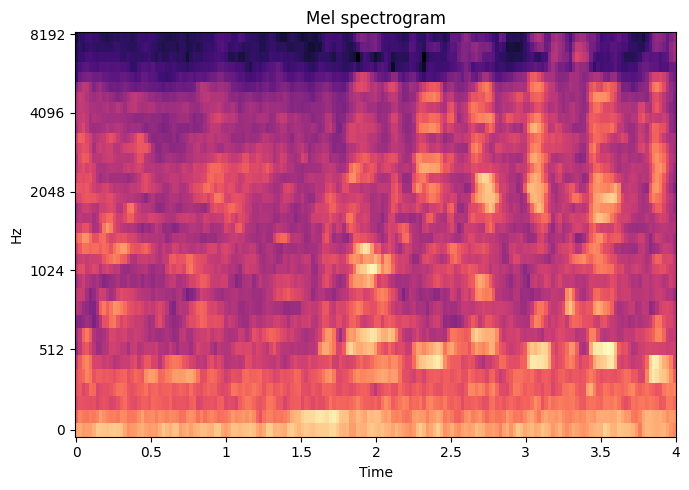

In [11]:
plt.figure(figsize=(7,5))
librosa.display.specshow(librosa.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.title('Mel spectrogram')
plt.tight_layout()